# import and load data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import importlib
import plottingTools as pt
from plottingTools import sample_to_8wells, sample_to_7wells, blank_wells
from scipy.stats import pearsonr, spearmanr
from matplotlib import cm, gridspec

avb_cols = {'pur':'#5B49B6', 
            'blu':'#52A4D9', 
            'tur':'#59C09D',
            'tea':'#B3EBAD',
            'yel': '#C3D64C',
            'gra':'#9B9B9D'}

/Users/davidding/anaconda3/envs/tf_env/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)
/Users/davidding/anaconda3/envs/tf_env/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/davidding/anaconda3/envs/tf_env/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
plt.style.use('/Users/davidding/PycharmProjects/pareSingleLibrary2/codebase/src/paper_style1.mplstyle')


In [3]:
%run -i 2012_load_data.py

# of nontoxic mutants in all concentrations 839
# of toxin mutants that are toxic in all conditions: 311
# of nontoxic mutants in all concentrations 855
# of toxin mutants that are toxic in all conditions: 781
len of mt_toxins: 310
len of ta_toxins 781
15
15
30
37


2012_load_data.py:636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_muts_mt_wt_toxin['t_pos_pdb'] = df_muts_mt_wt_toxin.t_mut.str[1:-1].astype(int) +1
2012_load_data.py:737: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_curr['at_mut'] = [at] * len(df_curr)


In [4]:
din = '/Users/davidding/Dropbox (HMS)/parESingleLibrary/ex58_evovlability_suprpessors/platereader/'
dout = '/Users/davidding/PycharmProjects/pareSingleLibrary2/codebase/pairedEnd/ex58/fig5/'


# combined growth rates

In [5]:

sample_wells = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9',
       'A10', 'A11', 'A12', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8',
       'B9', 'B10', 'B11', 'B12', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7',
       'C8', 'C9', 'C10', 'C11', 'C12', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6',
       'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'E1', 'E2', 'E3', 'E4', 'E5',
       'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'F1', 'F2', 'F3', 'F4',
       'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'G1', 'G2', 'G3',
       'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12', 'H1', 'H2',
       'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12']
# adds a continuous number of hours
def date_str_to_mins(date_str):
    # expects '0:14:10'
    hh, mm, ss = date_str.split(':')
    return float(hh) + (float(mm)+1)/60
    #date_str_to_mins('0:14:10')
    
# plate 1 get gr between 5 and 12 hours.

def get_gr(df_data1,sample_to_n , 
           sample_to_wells = sample_to_7wells, wells_exclude=[], 
           blank_wells=blank_wells, 
           sample_wells=sample_wells, 
           t1= 5, 
           t2=12,
          subtract_od_ts = True, # subtract grs, or divide grs
           use_log_od_diff = False
          ):
    
    # subtracting the blank well OD from the measurement wells
    blank = np.mean(df_data1[blank_wells], axis=1)
    for c in sample_wells:
        if c not in blank_wells:
            df_data1[c+'_from_blank'] = df_data1[c] - blank
            df_data1[c+'_from_blank_log'] = np.log(df_data1[c+'_from_blank']) 

    # add time in continuous hours
    df_data1['t_hrs'] = df_data1.apply(lambda r: date_str_to_mins(r.Time), axis=1)
    df_dat = df_data1.drop(columns='Time') # cannot convert to float
    df_dat = df_dat.astype(float)
    
    # get the mean of the blank at both timepoints, and the stdeviations
    #display(df_dat)
    #test this
    blank_mean_t1 = np.mean(np.matrix.flatten(df_dat.loc[df_dat.t_hrs ==t1][blank_wells].values))
    blank_std_t1 = np.std(np.matrix.flatten(df_dat.loc[df_dat.t_hrs ==t1][blank_wells].values))
    blank_mean_t2 = np.mean(np.matrix.flatten(df_dat.loc[df_dat.t_hrs ==t2][blank_wells].values))
    blank_std_t2 = np.std(np.matrix.flatten(df_dat.loc[df_dat.t_hrs ==t2][blank_wells].values))
    #print(blank_mean_t1, blank_std_t1)
    
    # for each sample, get the mean of the observcations, and the stdeviations at each time point
    sample_to_v_t1_mean = {}
    sample_to_v_t1_std = {}
    sample_to_v_t2_mean = {}
    sample_to_v_t2_std = {}
    
    for n, sample_n in sample_to_n.items():
        # get wells of interest
        wells = sample_to_wells[n]
        #keep only wells that are not outliers
        wells_keep = [well for well in wells if well not in wells_exclude]
        ind_vals_t1 = df_dat.loc[df_dat.t_hrs == t1][wells_keep]
        ind_vals_t2 = df_dat.loc[df_dat.t_hrs == t2][wells_keep]
        
        sample_to_v_t1_mean[sample_n] = np.mean(ind_vals_t1, axis=1).values[0]
        sample_to_v_t2_mean[sample_n] = np.mean(ind_vals_t2, axis=1).values[0]
        sample_to_v_t1_std[sample_n] = np.std(ind_vals_t1, axis=1).values[0]
        sample_to_v_t2_std[sample_n] = np.std(ind_vals_t2, axis=1).values[0]
        
    err_list = [blank_mean_t1, blank_std_t1, 
                    blank_mean_t2, blank_std_t2, 
                    sample_to_v_t1_mean, sample_to_v_t1_std, 
                    sample_to_v_t2_mean, sample_to_v_t2_std
                   ]
    #print(sample_to_v_t1_mean, sample_to_v_t1_std)
    # for each sample, calculate the sample_n to mean fold change
    # first calculate fold-change
    if subtract_od_ts:
        # take the difference in OD between 2 timepoints
        fold_ser = pd.DataFrame((df_dat.loc[df_dat.t_hrs ==t2].values - df_dat.loc[df_dat.t_hrs ==t1].values).reshape(1,-1),
                           columns= df_dat.columns)
    else:
        fold_ser = pd.DataFrame((df_dat.loc[df_dat.t_hrs ==t2].values / df_dat.loc[df_dat.t_hrs ==t1].values).reshape(1,-1),
                           columns= df_dat.columns)

    # second get the mean across the fold change series for a particular sample
    sample_n_to_fold_change = {}
    for n, sample_n in sample_to_n.items():
        # get wells of interest
        wells = sample_to_wells[n]
        #keep only wells that are not outliers
        wells_keep = [well for well in wells if well not in wells_exclude]
        # get the difference in wells for the ones that are different just the blank ones, not the log ones
        if not use_log_od_diff:
            wells_keep = [w+'_from_blank' for w in wells_keep]
        else:
            wells_keep = [w+'_from_blank_log' for w in wells_keep]
        #from the fold-series, fetch the wells to keep
        ind_traces = fold_ser[wells_keep]
        # caclulate mean change in OD and return
        mean_traces = np.mean(ind_traces, axis=1)
        sample_n_to_fold_change[sample_n] =mean_traces.values[0]
        
 
    return sample_n_to_fold_change, err_list

def norm_dic_linear(fch1):
    #normalizes a dictionary by how much the growth rates fall linearly between the scale of the wt toxin + and - antitoxin
    norm_fch1={}
    for m,v in fch1.items():
        if m not in ['wtT:wtAT', 'wtT:-AT']:
            norm_v = (v-fch1['wtT:-AT'])/ (fch1['wtT:wtAT'] - fch1['wtT:-AT'])
            norm_fch1[m] = norm_v
    return norm_fch1

def norm_dic_relative_wt(fch1):
    #normalizes a dictionary by how much the growth rates fall linearly between the scale of the wt toxin + and - antitoxin
    norm_fch1={}
    for m,v in fch1.items():
        if m not in ['wtT:wtAT']:
            norm_v = v-fch1['wtT:wtAT'] # just calculate relative gr
            norm_fch1[m] = norm_v
    return norm_fch1


'\n- currently: od-difference / od_difference range of +/- at\n- \n'

In [6]:

def get_all_grs(t1=5, t2=12, subtract_od_ts=True, use_log_od_diff=False, use_linear_scale=True):
    # get the grs for all the 210223 samples
    sample_to_n_1 = {1: 'wtT:wtAT',#'wt_t_at_411', 
                    2: 'wtT:-AT',#'mcs_at_dds441', 
                    3: 'wtT:G62L',#'G62L+292', # from 292 cells
                    4: 'wtT:W59T',#'W59T+292', # from 292 cells
                    5: 'wtT:F73K',#'F73K+292',
                    6: 'wtT:K63L',#'K63L+292',
                    7: 'V5L:-AT'#'401(wtAT)+420(V5L)', # from 401 cells, so it's broken
                  }
    df_data1 = pd.read_csv(din + '210223_ortho_p1_data.csv')

    fch1_old, err_list_1_old = get_gr(df_data1, sample_to_n = sample_to_n_1, 
                      t1=t1, t2=t2, 
                      subtract_od_ts=subtract_od_ts, 
                     use_log_od_diff=use_log_od_diff)

    
    
    
    sample_to_n_2 = {1: 'wtT:wtAT',#'wt_t_at_411', 
                    2: 'wtT:-AT',#'mcs_at_dds441', 
                    #3: 'A66F:-AT1',# see sample number 5 #'401(wtAT)+421(A66F)', # from 401 cells
                    4: 'V5L:-AT',#'395(-AT)+420(V5L)', # from 395 cells
                    5: 'A66F:-AT',#'395(-AT)+421(A66F)', # from 395 cells
                    6: 'V5L:G62L',#'G62L+420 (V5L)', # from G62L new cryo1 cells
                    7: 'V5L:W59T'#'W59T+420 (V5L)', # from W59T new cryo15 cells
                  }
    df_data2 = pd.read_csv(din + '210223_ortho_p2_data.csv')
    fch2_old, err_list_2_old = get_gr(df_data2, sample_to_n = sample_to_n_2,
                      t1=t1, t2=t2, 
                      subtract_od_ts=subtract_od_ts, 
                     use_log_od_diff=use_log_od_diff)


    # 210414 orthogonal growth rates
    sample_to_n_1 = {1: 'wtT:wtAT',#'wt_t_at_411', 
                    2: 'wtT:-AT',#'mcs_at_dds441', 
                    3: 'wtT:G62L',#'G62L+292', # from 292 cells
                    4: 'wtT:W59T',#'W59T+292', # from 292 cells
                    5: 'E37D:G62L',
                    6: 'G81Y:G62L',
                    7: 'P8A:G62L',
                     8: 'R52L:G62L'
                    }
    df_data1 = pd.read_csv(din + '210414_p1_1200_g62l_data.csv')
    fch1_new, err_list_1_new = get_gr(df_data1, sample_to_n = sample_to_n_1, 
                      sample_to_wells=sample_to_8wells, 
                      t1=t1, t2=t2, 
                      subtract_od_ts=subtract_od_ts, 
                     use_log_od_diff=use_log_od_diff)

    sample_to_n_2 = {1: 'wtT:wtAT',#'wt_t_at_411', 
                    2: 'wtT:-AT',#'mcs_at_dds441', 
                    3: 'wtT:G62L',#'G62L+292', # from 292 cells
                    4: 'wtT:W59T',#'W59T+292', # from 292 cells
                    5: 'P8N:W59T',
                    6: 'V75G:W59T',
                    7: 'G94_:W59T',
                     8: 'W85P:W59T'
                    }
    df_data2 = pd.read_csv(din + '210414_p2_1200_w59t_data.csv')
    # coz some of these have stuff growing
    blank_wells2 = [c for c in blank_wells if c not in ['A5', 'A6', 'A7']]

    fch2_new, err_list_2_new = get_gr(df_data2, sample_to_n = sample_to_n_2, 
                      sample_to_wells=sample_to_8wells, 
                      blank_wells = blank_wells2, 
                      t1=t1, t2=t2, 
                      subtract_od_ts=subtract_od_ts, 
                     use_log_od_diff=use_log_od_diff)

    if use_linear_scale:
        norm_fch1_old = norm_dic_linear(fch1_old)
        norm_fch2_old = norm_dic_linear(fch2_old)
        # normalize fold change
        norm_fch1_new = norm_dic_linear(fch1_new)
        norm_fch2_new = norm_dic_linear(fch2_new)
    else:
        norm_fch1_old = norm_dic_relative_wt(fch1_old)
        norm_fch2_old = norm_dic_relative_wt(fch2_old)
        # normalize fold change
        norm_fch1_new = norm_dic_relative_wt(fch1_new)
        norm_fch2_new = norm_dic_relative_wt(fch2_new)
        
    #combine dics
    norm_fch_all_old = norm_fch1_old
    norm_fch_all_old.update(norm_fch2_old)
    # combine growth rates
    norm_fch_all_new = norm_fch1_new
    norm_fch_all_new.update(norm_fch2_new)
    norm_fch_all = norm_fch_all_new
    norm_fch_all.update(norm_fch_all_old)

    return norm_fch_all, err_list_1_old, err_list_2_old, err_list_1_new, err_list_2_new
dic_fch, err_list_1_old, err_list_2_old, err_list_1_new, err_list_2_new  = get_all_grs(t1=2, t2=14)

/Users/davidding/anaconda3/envs/tf_env/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [7]:
def prop_error_norm_fch(v_t2, v_t1, p_t2, p_t1, n_t2, n_t1,
              s_v_t2, s_v_t1, s_p_t2, s_p_t1, s_n_t2, s_n_t1):
    # calculates propagated errors assuming independence of variables using only 2 time points of growth rate measurement
    # v stands for value of interest
    # p stands for positive control growth rate
    # n stand for negative control gr
    
    # gr_plot = (fold_change_v - fold_change_n)/ (fold_change_p - fold_change_n)
    
    # need values for 
    # standard deviations: s_v_t2, s_v_t1, s_p_t2, s_p_t1, s_n_t2, s_n_t1
    # and values of: v_t2, v_t1, p_t2, p_t1, n_t2, n_t1
    sums = (s_v_t2**2 + s_v_t1**2 + 
        (((v_t2 - v_t1 + n_t1) - (p_t2 - p_t1 + n_t1)) / ((p_t2 - p_t1 + n_t1) - n_t2)**2)**2 * s_n_t2**2 + # (d(gr)/d(nt2))**2 * (s_n_t2)**2 
        (((p_t2 - p_t1 - n_t2) - (v_t2 - v_t1 - n_t2)) / ((p_t2 - p_t1 - n_t2) - n_t1)**2 )**2 * s_n_t1**2 + # d(gr)/d(nt1) * s_n_t1
        (-(v_t2 - v_t1 - n_t2 + n_t1) / ((-p_t1- n_t2 + n_t1) + p_t2)**2)**2 * s_p_t2**2 +                   # d(gr)/d(p_t2) * s_p_t2
        ((v_t2 - v_t1 - n_t2 + n_t1) / ((p_t2 - n_t2 + n_t1) + p_t1)**2)**2 * s_p_t1**2                     # d(gr)/d(p_t1) * s_p_t1
           )
    #print(sums)
    std_gr = np.sqrt(sums)
    return std_gr
    
def get_errors_muts(err_list):
    blank_mean_t1, blank_std_t1, blank_mean_t2, blank_std_t2, sample_to_v_t1_mean, sample_to_v_t1_std, sample_to_v_t2_mean, sample_to_v_t2_std = err_list
    
    sample_n_to_std = {}
    for sample_n in sample_to_v_t1_mean.keys():
        if sample_n not in ['wtT:wtAT', 'wtT:-AT']:
            v_t2 = sample_to_v_t2_mean[sample_n]  
            v_t1 = sample_to_v_t1_mean[sample_n] 
            p_t2 = sample_to_v_t2_mean['wtT:wtAT'] 
            p_t1 = sample_to_v_t1_mean['wtT:wtAT'] 
            n_t2 = blank_mean_t2
            n_t1 = blank_mean_t1
            s_v_t2 = sample_to_v_t2_std[sample_n] 
            s_v_t1 = sample_to_v_t1_std[sample_n]
            s_p_t2 = sample_to_v_t2_std['wtT:wtAT'] 
            s_p_t1 = sample_to_v_t1_std['wtT:wtAT']
            s_n_t2 = blank_std_t2
            s_n_t1 = blank_std_t1
            std_fold = prop_error_norm_fch(v_t2, v_t1, p_t2, p_t1, n_t2, n_t1,
              s_v_t2, s_v_t1, s_p_t2, s_p_t1, s_n_t2, s_n_t1)
            sample_n_to_std[sample_n] = std_fold
    
    return sample_n_to_std

#this gets the propagated errors in the fold change calculation

sample_to_std_1_old = get_errors_muts(err_list_1_old)
sample_to_std_2_old = get_errors_muts(err_list_2_old)
sample_to_std_1_new = get_errors_muts(err_list_1_new) 
sample_to_std_2_new = get_errors_muts(err_list_2_new)

#combine them
sample_to_std_1_old.update(sample_to_std_2_old)
sample_to_std_1_new.update(sample_to_std_2_new)

sample_to_std_1_new.update(sample_to_std_1_old)
sample_to_std_1_new

{'wtT:G62L': 0.04511340934320033,
 'wtT:W59T': 0.04513472197607554,
 'E37D:G62L': 0.032774003962309645,
 'G81Y:G62L': 0.04538767567463893,
 'P8A:G62L': 0.028264585496983557,
 'R52L:G62L': 0.049457702878495095,
 'P8N:W59T': 0.0286008153378241,
 'V75G:W59T': 0.04754183328489533,
 'G94_:W59T': 0.05046061923117791,
 'W85P:W59T': 0.04982622403869411,
 'wtT:F73K': 0.05140355805146509,
 'wtT:K63L': 0.05229518174895317,
 'V5L:-AT': 0.02646750225415425,
 'A66F:-AT': 0.018547765808518833,
 'V5L:G62L': 0.06072917289619021,
 'V5L:W59T': 0.06157716773967678}

In [8]:
# load in a file
'''
# 
need_ats = ['G62L', 'W59T', 'F73K', 'K63L']
need_at_to_errs_tup ={}

for at in need_ats:
    print(at_to_f_l[at])

for at in ['G62L', 'W59T', 'F73K', 'K63L']:
    print(at)
    bayes_mcs_dir_ex47 = '/Users/davidding/Dropbox (HMS)/parESingleLibrary/ex51_set_up_additional_mutants/illumina/data/bayes_o2_2009/raw/doubles_ex47_l/'
    bayes_mcs_dir_ex51 = '/Users/davidding/Dropbox (HMS)/parESingleLibrary/ex51_set_up_additional_mutants/illumina/data/bayes_o2_2009/raw/doubles_ex51_l/'

    if at != 'K63L':
        df_fit_curr = pd.read_csv(bayes_mcs_dir_ex47 + 'df_sm_bhs_diff_w_aa_m_178_'+at+'.csv')
    else:
        df_fit_curr = pd.read_csv(bayes_mcs_dir_ex51 + 'df_sm_bhs_diff_w_aa_m_178_'+at+'.csv')
    
    # need to correct for log2 scaling
    samples = df_fit_curr['w_aa']/np.log(2)
    pickle.dump(samples, open(plot_out + 'samples_'+at+'.p', 'wb'))
    w_aa_mean_curr = np.mean(samples)
    w_aa_dist_curr_hdi_lower  = np.percentile(samples, 2.5, axis=0)
    w_aa_dist_curr_hdi_upper = np.percentile(samples, 97.5, axis=0)
    err_low = -w_aa_dist_curr_hdi_lower + w_aa_mean_curr
    err_high = w_aa_dist_curr_hdi_upper - w_aa_mean_curr
    
    need_at_to_errs_tup[at] = (err_low, err_high)
    
    pickle.dump(need_at_to_errs_tup, open(plot_out + 'need_at_to_errs_tup.p', 'wb'))

'''
need_at_to_errs_tup = pickle.load(open(plot_out + 'need_at_to_errs_tup.p', 'rb'))

(0.9451409112173671, 3.466066972823714e-08)
16


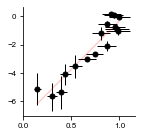

In [9]:
# this is the differene in OD, linearly scaled to the wild type +/- AT case.

dic_in, err_list_1_old, err_list_2_old, err_list_1_new, err_list_2_new  = get_all_grs(t1=2, t2=14)

el_width = 1
alpha=1
ms=10

plt.figure(figsize=(2, 2))
x = list(dic_in.values())
y = [df_muts.loc[df_muts.muts == v].yobs_from_wt.values[0] for v in dic_in.keys()]

y_err = [df_muts.loc[df_muts.muts == v].yobs_errors.values[0] for v in dic_in.keys()]

# split y_errors
y_err_low = [float(v[0]) if str(v) != 'nan' else 0 for v in y_err]
y_err_high = [float(v[1]) if str(v) != 'nan' else 0 for v in y_err]


# add v5l and A66F errors, get from mcs df_percentile
df_mcs = pd.read_csv('/Users/davidding/Dropbox (HMS)/parESingleLibrary/ex51_set_up_additional_mutants/illumina/data/bayes_o2_2009/log2/doubles_ex47_l/df_percentiles_diff_w_aa_m_178_mcsAT.csv')
v5l_r = df_mcs.loc[df_mcs.aa_mut == 'V5L']
v5l_err_low = v5l_r['2.5%'] - v5l_r.mean_fit
v5l_err_high = v5l_r['97.5%'] - v5l_r.mean_fit

y_err_low[-4] = v5l_err_low.values[0]
y_err_high[-4] = v5l_err_high.values[0]

a66f_r = df_mcs.loc[df_mcs.aa_mut == 'A66F']
a66f_err_low = a66f_r['2.5%'] - a66f_r.mean_fit
a66f_err_high = a66f_r['97.5%'] - a66f_r.mean_fit

y_err_low[-3] = a66f_err_low.values[0]
y_err_high[-3] = a66f_err_high.values[0]


# get the synonyous 95% HDI's
y_err_low[0] = need_at_to_errs_tup['G62L'][0]
y_err_high[0] = need_at_to_errs_tup['G62L'][1]

y_err_low[1] = need_at_to_errs_tup['W59T'][0]
y_err_high[1] = need_at_to_errs_tup['W59T'][1]

y_err_low[-6] = need_at_to_errs_tup['F73K'][0]
y_err_high[-6] = need_at_to_errs_tup['F73K'][1]

y_err_low[-5] = need_at_to_errs_tup['K63L'][0]
y_err_high[-5] = need_at_to_errs_tup['K63L'][1]

# x error as 2 * std
x_err = 2*np.array([v for v in sample_to_std_1_new.values()])

plt.errorbar(
    x,y, 
    yerr=[-np.array(y_err_low), y_err_high], 
    xerr=[x_err, x_err],
    alpha=alpha, elinewidth=el_width, fmt=".", ms=ms,
    color='black'
)

plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), 
         color='red', alpha=0.2)

plt.xticks([0,0.5,1], size=8)
plt.yticks(size=8)


print(pearsonr(x,y))
print(len(x))
#plt.scatter(x,y)
plt.savefig(plot_out + 'linear_scaled_gr_diff.svg', format='svg')

